In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

In [2]:
from pathlib import Path

product_data = ["products-data-0", "products-data-1", "products-data-2"]
review_data = ["reviews-0", "reviews-1", "reviews-2"]
file_path = Path("/Users/zulikahlatief/Desktop/personal/ecommerce/dataset")

dfs = [pd.read_csv(file_path / f"{x}.tsv", sep='\t', names=['id', 'category', 'title']) for x in product_data]
product_df = pd.concat(dfs, ignore_index=True)

review_dfs = []
for x in review_data:
    if x == "reviews-2":
        # Handle different column order for "reviews-2"
        df = pd.read_csv(file_path / f"{x}.tsv", sep='\t', header=None, names=['rating', 'id', 'review'])
    else:
        # Assume the default column order for "reviews-0" and "reviews-1"
        df = pd.read_csv(file_path / f"{x}.tsv", sep='\t', header=None, names=['id', 'rating', 'review'])
    
    review_dfs.append(df)

review_df = pd.concat(review_dfs, ignore_index=True)

df = pd.merge(product_df, review_df, on='id')
labels = df.pop('category')

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)
numerical_cols = ["rating"]

# Standardize numerical ratings
scaler = StandardScaler()
X_train_numerical_cols = scaler.fit_transform(X_train[numerical_cols])
X_test_numerical_cols = scaler.transform(X_test[numerical_cols])

# Standardize text columns
# Combine text columns
X_train['combined_text'] = X_train['title'] + ' ' + X_train['review']
X_test['combined_text'] = X_test['title'] + ' ' + X_test['review']

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_train = tfidf_vectorizer.fit_transform(X_train['combined_text'])
tfidf_matrix_test = tfidf_vectorizer.transform(X_test['combined_text'])

# Combine TF-IDF features with the 'rating' column
X_train = pd.concat([pd.DataFrame(tfidf_matrix_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out()), pd.DataFrame(X_train_numerical_cols, columns=numerical_cols)], axis=1)
X_test = pd.concat([pd.DataFrame(tfidf_matrix_test.toarray(), columns=tfidf_vectorizer.get_feature_names_out()), pd.DataFrame(X_test_numerical_cols, columns=numerical_cols)], axis=1)

# Encode 'category' column
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
X_train.describe()

Test Accuracy: 0.98


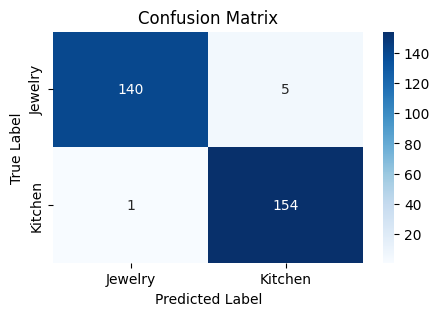

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns

# Train a logistic regression model
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_regression_model.predict(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy_test}")

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using seaborn
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [8]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(logistic_regression_model, X_train, y_train, cv=7, scoring='accuracy')
scores_log_loss = cross_val_score(logistic_regression_model, X_train, y_train, cv=7, scoring='neg_log_loss')

print('Cross-Validation Accuracy Scores', scores)
print('Cross-Validation loss', scores_log_loss)

Cross-Validation Accuracy Scores [0.96511628 0.98255814 0.97674419 0.97660819 0.98830409 0.98245614
 0.96491228]
Cross-Validation loss [-0.2964957  -0.28320313 -0.28576214 -0.27820644 -0.27806782 -0.28422092
 -0.28917272]


Cross-Validation Accuracy: 0.9725


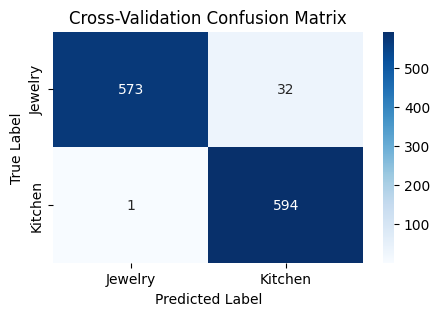

In [10]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

# Create a logistic regression model
logistic_regression_model = LogisticRegression()

# Use StratifiedKFold for k-fold cross-validation
kf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

# Perform k-fold cross-validation and obtain predictions
y_pred_cv = cross_val_predict(logistic_regression_model, X_train, y_train, cv=kf)

# Calculate accuracy for each fold
accuracy_cv = accuracy_score(y_train, y_pred_cv)
print(f"Cross-Validation Accuracy: {accuracy_cv}")

# Create a confusion matrix
conf_matrix_cv = confusion_matrix(y_train, y_pred_cv)

# Display the confusion matrix using seaborn
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_cv, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Cross-Validation Confusion Matrix')
plt.show()